# Euclid AAS 247 Workshop -- 2a. Nearby Galaxy Morphology

## Learning Goals

By the end of this tutorial, you will: 
- Understand how to access data from the photo-z catalog
- Use the photo-z catalog to find the redshift and object IDs of galaxies
- Download the MER image of one of those galaxies to inspect the galaxy morphology.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA. The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe. The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals. These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields: Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

This exercise notebook gives you the opportunity to use the photo-z catalog to find low redshift galaxies, find their object IDs, and then find their MER images to inspect the galaxy morphology.

## Data volume

Each MER image is approximately 1.47 GB. Downloading can take some time.

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install numpy 'astropy>=5.3' matplotlib 'astroquery>=0.4.10' 'sep>=1.4' fsspec

In [2]:
import re

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch,  ZScaleInterval, SquaredStretch
from astropy.wcs import WCS
from astropy import units as u

from astroquery.ipac.irsa import Irsa
import sep

import pandas as pd
import json

import s3fs

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# ## Set a longer timeout (default is 60 seconds)
Irsa.TIMEOUT = 300  # 5 minutes

# Euclid Q1 Nearby Galaxy Morphology

## 1. Search for Euclid PHZ photo-z catalog to find low redshift galaxies

Helpful notebooks -- 1b_Catalog_Access

Use the Euclid Photo-z catalog ('Euclid Q1 PHZ Photo-z Catalog') to find the redshift ('phz_median') and object IDs ('object_id') of nearby (z<0.5) galaxies ('phz_classification' = 2).

In [5]:
Irsa.list_catalogs(filter='euclid')

{'euclid.tileid_association_q1': 'Euclid Q1 TILEID to Observation ID Association Table',
 'euclid.objectid_spectrafile_association_q1': 'Euclid Q1 Object ID to Spectral File Association Table',
 'euclid.observation_euclid_q1': 'Euclid Q1 CAOM Observation Table',
 'euclid.plane_euclid_q1': 'Euclid Q1 CAOM Plane Table',
 'euclid.artifact_euclid_q1': 'Euclid Q1 CAOM Artifact Table',
 'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_

In [6]:
table_phz= 'euclid_q1_phz_photo_z'


In [7]:
columns_info = Irsa.list_columns(catalog=table_phz)
print(len(columns_info))

67


In [8]:
columns_info

{'object_id': 'Unique ID of the object in the survey, as set by MER',
 'phz_median': 'The median of the PHZ PDF',
 'phz_mode_1': 'The first mode of the PHZ PDF',
 'phz_mode_1_area': 'The total area of the first mode',
 'phz_mode_2': 'The second mode of the PHZ PDF',
 'phz_mode_2_area': 'The total area of the second mode',
 'bias_id': 'The identifier to be used for retrieving the bias correction shift from the bias correction map',
 'tom_bin_id': 'The identifier of the tomographic bin the source belongs to (Equipopulated-bins)',
 'alt_tom_bin_id': 'The identifier of the alternate tomographic bin the source belongs to (Equidistant-bins)',
 'pos_tom_bin_id': 'The identifier of the photometric clustering tomographic bin the source belongs to (Equipopulated-bins)',
 'flag_som_tomobin': 'Flag telling if the source belong to a combination of SOM cell and Tom. bin which can be calibrated (=1) or not (=0).',
 'flag_som_alt_tomobin': 'Flag telling if the source belong to a combination of SOM cel

In [9]:
adql_phz = f"SELECT TOP 10 phz.object_id, phz.phz_median, phz.phz_classification, phz.flux_vis_unif \
FROM {table_phz} AS phz \
WHERE  phz.phz_median <0.05 \
AND phz.phz_classification =2 \
AND phz.phz_median > 0.0 \
ORDER BY phz.phz_median \
"

## Run the query
result_phz = Irsa.query_tap(adql_phz).to_table()

In [10]:
result_phz

object_id,phz_median,phz_classification,flux_vis_unif
,,,uJy
int64,float32,int64,float64
-581003267496850096,0.009999999776,2,435789.3102
-529295438289344256,0.009999999776,2,362943.3351
-529662372290047822,0.009999999776,2,263.8782307
-527977852288327002,0.009999999776,2,165523.6245
-581428896495925801,0.009999999776,2,104581.2307
-577100472495819274,0.009999999776,2,23764.60579
-576644881494782368,0.009999999776,2,188900.0645
-530000030288427286,0.009999999776,2,539837.554


## 2. Join the PHZ catalog with the MER catalog to find the RA and Dec of a galaxy of your choice.

Helpful notebooks -- 1b_Catalog_Access

Join the Euclid PHZ catalog ('Euclid Q1 PHZ Photo-z Catalog') and the Euclid MER catalog ('euclid_q1_mer_catalogue') on "object_id".

Use the Euclid MER catalog ('euclid_q1_mer_catalogue') to find the sizes ('kron_radius') and RA ('ra'), Dec ('dec'), and Tile ID ('tileid') for the lowest redshift galaxies in the Q1 PHZ catalog.

In [11]:
table_mer= 'euclid_q1_mer_catalogue'

In [12]:
columns_info_mer = Irsa.list_columns(catalog=table_mer)
columns_info_mer

{'flux_g_ext_hsc_templfit': 'Gext HSC band source template fitting flux (TPHOT measurement)',
 'flux_z_ext_hsc_templfit': 'Zext HSC band source template fitting flux (TPHOT measurement)',
 'fluxerr_y_templfit': 'NIR Y band source template fitting flux error (TPHOT measurement)',
 'fluxerr_j_templfit': 'NIR J band source template fitting flux error (TPHOT measurement)',
 'fluxerr_h_templfit': 'NIR H band source template fitting flux error (TPHOT measurement)',
 'fluxerr_u_ext_decam_templfit': 'Uext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_g_ext_decam_templfit': 'Gext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_r_ext_decam_templfit': 'Rext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_i_ext_decam_templfit': 'Iext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_z_ext_decam_templfit': 'Zext DECam band source template fitting flux error (TPHOT measurement)',
 

In [13]:
adql_join = f"""
SELECT TOP 10 
    mer.ra, 
    mer.dec, 
    mer.tileid, 
    mer.kron_radius,
    mer.semimajor_axis,
    phz.object_id,
    phz.phz_median, 
    phz.phz_classification, 
    phz.flux_vis_unif
FROM {table_mer} AS mer
JOIN {table_phz} AS phz
    ON mer.object_id = phz.object_id
WHERE 
    phz.phz_median < 0.05
    AND phz.phz_classification = 2
ORDER BY 
    mer.kron_radius DESC,
    phz.phz_median ASC
"""

## Run the query
result_join = Irsa.query_tap(adql_join).to_table()
#####################

In [14]:
result_join

ra,dec,tileid,kron_radius,semimajor_axis,object_id,phz_median,phz_classification,flux_vis_unif
deg,deg,,pix,pix,,,,uJy
float64,float64,int64,float32,float32,int64,float32,int64,float64
63.40114100,-46.19332494,102023479,14168.23242,1620.366211,-634011409461933249,0.01999999955,2,82554.91335
266.06721583,66.55071831,102159483,13753.75684,1484.776489,2660672158665507183,0.02999999933,2,26557.12238
274.96013578,65.87923491,102159196,13117.93164,1873.990234,2749601357658792349,0.01999999955,2,65849.2001
274.14262704,65.48541870,102158895,13045.23633,1693.488892,2741426270654854186,0.009999999776,2,235755.4984
52.47442766,-29.36159553,102042284,11649.71387,943.7918701,-524744276293615955,0.03999999911,2,19267.68793
61.39881437,-46.11407659,102023476,11343.55176,1010.893921,-613988143461140765,0.03999999911,2,19953.15437
269.42032410,68.02537317,102160336,10251.59375,1238.555176,2694203240680253731,0.01999999955,2,61869.86385
62.03123859,-49.17793092,102020536,9916.107422,1067.504639,-620312385491779309,0.01999999955,2,170708.9582


In [15]:
## Note the tile ID for the next exercise:
print("The tile ID for the object of interest is",result_join['tileid'][0]," and the object ID is ",result_join['object_id'][0])

The tile ID for the object of interest is 102023479  and the object ID is  -634011409461933249


## 3. Use the RA and Dec to read in the MER image from the cloud

Helpful notebooks -- 1a_Image_Access

Use the RA and Dec from the MER catalog above to find and read in the relevant MER image from the cloud.

In [22]:
## Define the center of the Fornax Deep Field
ra = result_join['ra'][0]
dec = result_join['dec'][0]

## Convert from RA and Dec to a "SkyCoord" object using an astropy function
coord_radec = SkyCoord(ra=ra, dec=dec, unit='deg')

## Define the search radius you want to search for images within.
search_radius_radec = 1 * u.arcsec

image_table_radec = Irsa.query_sia(pos=(coord_radec, search_radius_radec), collection='euclid_DpdMerBksMosaic')

In [23]:
## Convert the table to a pandas dataframe
df_radec=image_table_radec.to_pandas()

In [24]:
df_sci = df_radec[(df_radec['dataproduct_subtype'] == 'science') & (df_radec['facility_name'] == 'Euclid') ].copy()


In [25]:
df_sci

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id,dist_to_point
2,63.48894,-45.999986,Euclid,NISP,science,3,image,Y,Infrared,102023479_NISP,0.0878,9.200000e-07,1.146000e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102023479-FCB084_20241018T190839.119135Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102023479_NISP/Y,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102023479-FCB084_20241018T190839.119135Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.202684
4,63.48894,-45.999986,Euclid,NISP,science,3,image,H,Infrared,102023479_NISP,0.1026,1.372000e-06,2.000000e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102023479-1946B4_20241018T190900.444731Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102023479_NISP/H,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102023479-1946B4_20241018T190900.444731Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.202684
5,63.48894,-45.999986,Euclid,NISP,science,3,image,J,Infrared,102023479_NISP,0.0940,1.146000e-06,1.372000e-06,5.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102023479-CDB9AA_20241018T184512.863866Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102023479_NISP/J,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102023479-CDB9AA_20241018T184512.863866Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.202684
6,63.48894,-45.999986,Euclid,VIS,science,3,image,VIS,Optical,102023479_VIS,0.1600,5.500000e-07,9.000000e-07,2.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102023479-3C020F_20241018T200121.586007Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,

## 4. Retreive a smaller cutout of the Euclid Q1 MER mosaic image from the cloud of a region of interest

#### Due to the large file size, retrieve only a smaller cutout in a region of interest using fsspec and Cutout2D

In [26]:
## Convert the "cloud_access" column into the location of the image file on the cloud

df_sci["cloud_dict"] = df_sci["cloud_access"].apply(json.loads)
df_sci["s3_path"] = df_sci["cloud_dict"].apply(
    lambda d: f"{d['aws']['bucket_name']}/{d['aws']['key']}"
)

In [27]:
df_sci

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id,dist_to_point,cloud_dict,s3_path
2,63.48894,-45.999986,Euclid,NISP,science,3,image,Y,Infrared,102023479_NISP,0.0878,9.200000e-07,1.146000e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102023479-FCB084_20241018T190839.119135Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102023479_NISP/Y,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102023479-FCB084_20241018T190839.119135Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.202684,"{'aws': {'bucket_name': 'nasa-irsa-euclid-q1', 'key': 'q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102023479-FCB084_20241018T190839.119135Z_00.00.fits', 'region': 'us-east-1'}}",nasa-irsa-euclid-q1/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102023479-FCB084_20241018T190839.119135Z_00.00.fits
4,63.48894,-45.999986,Euclid,NISP,science,3,image,H,Infrared,102023479_NISP,0.1026,1.372000e-06,2.000000e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102023479-1946B4_20241018T190900.444731Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102023479_NISP/H,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102023479-1946B4_20241018T190900.444731Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.202684,"{'aws': {'bucket_name': 'nasa-irsa-euclid-q1', 'key': 'q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102023479-1946B4_20241018T190900.444731Z_00.00.fits', 'region': 'us-east-1'}}",nasa-irsa-euclid-q1/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102023479-1946B4_20241018T190900.444731Z_00.00.fits
5,63.48894,-45.999986,Euclid,NISP,science,3,image,J,Infrared,102023479_NISP,0.0940,1.146000e-06,1.372000e-06,5.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102023479-CDB9AA_20241018T184512.863866Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 63.87097451623507 -45.73268481095574 63.1069050896618 -45.73268467832832 63.10320468378337 -46.26600218921831 63.87467453670924 -46.26600232433946 63.87097451623507 -45.73268481095574,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102023479_NISP/J,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102023479/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102023479-CDB9AA_20241018T184512.863866Z_00.00.fit

In [28]:
## Select the VIS-band row
row = df_sci[df_sci["energy_bandpassname"] == "VIS"].iloc[0]

## Extract the S3 path
s3_fpath = row["s3_path"]

## Open the FITS file from the cloud using fsspec
with fits.open(f's3://{s3_fpath}', fsspec_kwargs={"anon": True}) as hdul:
    print(f'Retrieving cutout for VIS-band')
    
    ## Store the original header
    header = hdul[0].header
    
    ## Read in the cutout of the image that you want
    cutout_data = Cutout2D(
        hdul[0].data,
        position=coords_cutout,
        size=im_cutout,
        wcs=WCS(header)
    )

## Define a new FITS file based on this smaller cutout,
## with accurate WCS based on the cutout size
new_hdu = fits.PrimaryHDU(data=cutout_data.data, header=header)
new_hdu.header.update(cutout_data.wcs.to_header())

KeyboardInterrupt: 

### Plot the cutout image with RA and Dec axes.

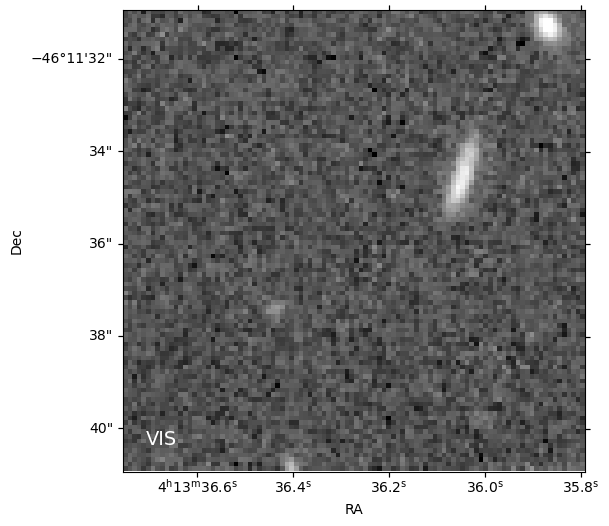

In [98]:
## Create a normalization for better contrast in the image
norm = ImageNormalize(new_hdu.data, interval=PercentileInterval(99.9), stretch=AsinhStretch())

## Use the WCS from the cutout
wcs = WCS(new_hdu.header)  

## Create figure and axes with WCS projection
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': wcs})

im = ax.imshow(new_hdu.data, cmap='gray', origin='lower', norm=norm)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.05, 0.05, 'VIS', color='white', fontsize=14,
        transform=ax.transAxes, va='bottom', ha='left')

plt.show()

## About this Notebook

**Author(s)**: Tiffany Meshkat <br>
**Keyword(s)**: Euclid, Q1, AAS 247 Workshop <br>
**First published**: TBD <br>
**Last updated**: TBD, 2025